In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best_topomorph/keras/default/1/best_topomorph.h5
/kaggle/input/botswana/Botswana_gt.mat
/kaggle/input/botswana/Botswana.mat


In [3]:
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Input, GlobalAveragePooling2D
import matplotlib.pyplot as plt


2025-07-29 12:21:17.052152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753791677.419793      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753791677.526200      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [5]:
# --- Load Dataset ---
data = scipy.io.loadmat('/kaggle/input/botswana/Botswana.mat')['Botswana'] #(1476, 256, 145)
gt = scipy.io.loadmat('/kaggle/input/botswana/Botswana_gt.mat')['Botswana_gt'] #(1476, 256)

In [6]:
# --- Normalize ---
data_reshaped = data.reshape(-1, data.shape[-1]) #(377856, 145)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_reshaped).reshape(data.shape) #(1476, 256, 145)

In [7]:
# --- MBSA Band Selection ---
def morphological_band_saliency_selection(data, top_k=30):
    from skimage.morphology import opening, closing, disk
    h, w, bands = data.shape
    saliency = np.zeros(bands)
    for b in range(bands):
        band_img = data[:, :, b]
        morph_open = opening(band_img, disk(3))
        morph_close = closing(band_img, disk(3))
        saliency[b] = np.mean(np.abs(band_img - morph_open)) + np.mean(np.abs(band_img - morph_close))
    top_indices = np.argsort(saliency)[-top_k:]
    return np.sort(top_indices)

selected_bands = morphological_band_saliency_selection(data_scaled, top_k=30) #array([30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 60, 61,
       # 65, 66, 70, 71, 73, 74, 75, 76, 77, 78, 79, 84, 86])  shape=(30,)
data_selected = data_scaled[:, :, selected_bands] #(1476, 256, 30)

In [8]:
# --- Patch + Label Extraction ---
PATCH_SIZE = 13
pad = PATCH_SIZE // 2
data_padded = np.pad(data_selected, ((pad, pad), (pad, pad), (0, 0)), mode='symmetric')

patches, labels = [], []
for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
        if gt[i, j] > 0:
            patch = data_padded[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            patches.append(patch)
            labels.append(gt[i, j] - 1)

X_patches = np.array(patches) #(3248, 13, 13, 30)
y_labels = np.array(labels) #(3248,)
num_classes = len(np.unique(y_labels)) #14
y_true_cat = to_categorical(y_labels, num_classes=num_classes) #(3248, 14)

In [9]:
# --- Topological Features (Dummy) ---
topo_features = np.random.rand(len(X_patches), 32) #(3248, 32)

In [10]:
# --- Train-Test Split ---
X_train, X_test, topo_train, topo_test, y_train, y_test = train_test_split(
    X_patches, topo_features, y_true_cat, test_size=0.2, stratify=y_labels, random_state=42) #(2598, 13, 13, 30), (650, 13, 13, 30), (2598, 32), (650, 32), (2598, 14), (650, 14) 

In [11]:
# --- Load Your Pretrained Model ---
from tensorflow.keras.models import load_model
old_model = load_model('/kaggle/input/best_topomorph/keras/default/1/best_topomorph.h5', compile=False)

I0000 00:00:1753791715.102976      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753791715.103696      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
num_classes = 14  # For Botswana
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model, load_model

# Get all layers except final Dense
x = old_model.layers[-3].output  # The one before the last dense layer (GlobalAvgPool)
new_output = layers.Dense(num_classes, activation='softmax')(x)

# New model with same input
new_model = Model(inputs=old_model.input, outputs=new_output)

# Compile
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = new_model.fit(
    [X_train, topo_train],
    y_train,
    validation_data=([X_test, topo_test], y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1753791722.814297     101 service.cc:148] XLA service 0x7cd858219760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753791722.815896     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753791722.815916     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753791723.521843     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/82 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0517 - loss: 2.7758

I0000 00:00:1753791728.049775     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.1557 - loss: 2.4813 - val_accuracy: 0.4508 - val_loss: 1.7904
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5297 - loss: 1.3504 - val_accuracy: 0.7046 - val_loss: 0.7801
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7159 - loss: 0.7839 - val_accuracy: 0.7231 - val_loss: 0.6884
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7906 - loss: 0.5443 - val_accuracy: 0.7769 - val_loss: 0.7670
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8008 - loss: 0.6137 - val_accuracy: 0.9123 - val_loss: 0.2663
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9212 - loss: 0.2425 - val_accuracy: 0.9508 - val_loss: 0.1823
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8303 - loss: 0.4900 - val_accuracy: 0.9385 - val_loss: 0.1702
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9357 - loss: 0.1865 - val_accuracy: 0.8754 - val_loss: 0.2926
E

In [14]:
results={}

In [106]:
percentages = [0.3, 0.5, 0.7,0.8,0.9]
results_by_percent = {}  # Final result holder

In [109]:
def evaluate_models(X_patches, topo_features, y_true_cat, y_labels, split_ratio):
    results = {}

    # NewModel (TopoMorph RGNet)
    y_probs = new_model.predict([X_test, topo_test], verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    results["Proposed"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # KNN
    knn.fit(X_train.reshape((X_train.shape[0], -1)), np.argmax(y_train, axis=1))
    y_pred = knn.predict(X_test.reshape((X_test.shape[0], -1)))
    y_true = np.argmax(y_test, axis=1)
    results["KNN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # CNN
    cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
    results["CNN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # CNN Encoder
    cnn_encoder.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(cnn_encoder.predict(X_test, verbose=0), axis=1)
    results["CNN_Encoder"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # RNN
    rnn.fit(X_rnn_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(rnn.predict(X_rnn_test, verbose=0), axis=1)
    results["RNN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # GTFN
    gtfn_model.fit(topo_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(gtfn_model.predict(topo_test, verbose=0), axis=1)
    results["GTFN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    return results


In [110]:
for pct in percentages:
    res = evaluate_models(X_patches, topo_features, y_true_cat, y_labels, split_ratio=pct)
    results_by_percent[f"{int(pct*100)}%"] = res

In [111]:
# Overall Accuracy for each model at each sample size
for pct in results_by_percent:
    print(f"{pct} results:")
    for model_name, metrics in results_by_percent[pct].items():
        print(f"  {model_name} - OA: {metrics['OA']:.4f}, AA: {metrics['AA']:.4f}")

30% results:
  TopoMorph - OA: 0.9954, AA: 0.9957
  KNN - OA: 0.9754, AA: 0.9763
  CNN - OA: 0.9631, AA: 0.9656
  CNN_Encoder - OA: 0.9892, AA: 0.9870
  RNN - OA: 0.8769, AA: 0.8726
  GTFN - OA: 0.0938, AA: 0.0805
50% results:
  TopoMorph - OA: 0.9954, AA: 0.9957
  KNN - OA: 0.9754, AA: 0.9763
  CNN - OA: 0.9338, AA: 0.9310
  CNN_Encoder - OA: 0.9938, AA: 0.9916
  RNN - OA: 0.9662, AA: 0.9669
  GTFN - OA: 0.0754, AA: 0.0692
70% results:
  TopoMorph - OA: 0.9954, AA: 0.9957
  KNN - OA: 0.9754, AA: 0.9763
  CNN - OA: 0.9985, AA: 0.9987
  CNN_Encoder - OA: 0.9969, AA: 0.9968
  RNN - OA: 0.9831, AA: 0.9834
  GTFN - OA: 0.0923, AA: 0.0825
80% results:
  TopoMorph - OA: 0.9954, AA: 0.9957
  KNN - OA: 0.9754, AA: 0.9763
  CNN - OA: 0.9892, AA: 0.9887
  CNN_Encoder - OA: 0.9846, AA: 0.9823
  RNN - OA: 0.9985, AA: 0.9981
  GTFN - OA: 0.0846, AA: 0.0755
90% results:
  TopoMorph - OA: 0.9954, AA: 0.9957
  KNN - OA: 0.9754, AA: 0.9763
  CNN - OA: 0.9969, AA: 0.9974
  CNN_Encoder - OA: 0.9985, AA: 

In [113]:
results

{'Proposed': {'OA': 0.9953846153846154,
  'AA': 0.9957371489009287,
  'Precision': 0.9960020371785079,
  'Recall': 0.995559334845049,
  'F1': 0.9957371489009287,
  'Kappa': 0.9949991152280788,
  'mIoU': 0.9915613720235569,
  'F1_per_class': array([1.        , 1.        , 1.        , 1.        , 0.99082569,
         0.99065421, 1.        , 1.        , 0.992     , 0.99009901,
         1.        , 0.98591549, 0.99082569, 1.        ]),
  'Precision_per_class': array([1.        , 1.        , 1.        , 1.        , 0.98181818,
         1.        , 1.        , 1.        , 1.        , 0.98039216,
         1.        , 1.        , 0.98181818, 1.        ]),
  'Recall_per_class': array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.98148148, 1.        , 1.        , 0.98412698, 1.        ,
         1.        , 0.97222222, 1.        , 1.        ])},
 'SVM': {'OA': 0.9876923076923076,
  'AA': 0.9861637930063815,
  'Precision': 0.9869257976674856,
  'Recall': 0.98577097505668

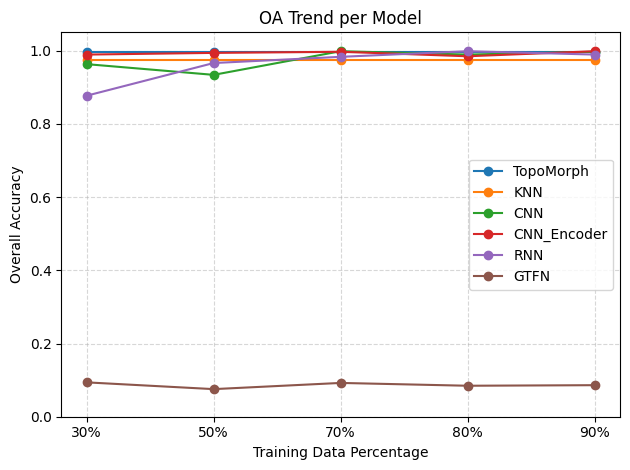

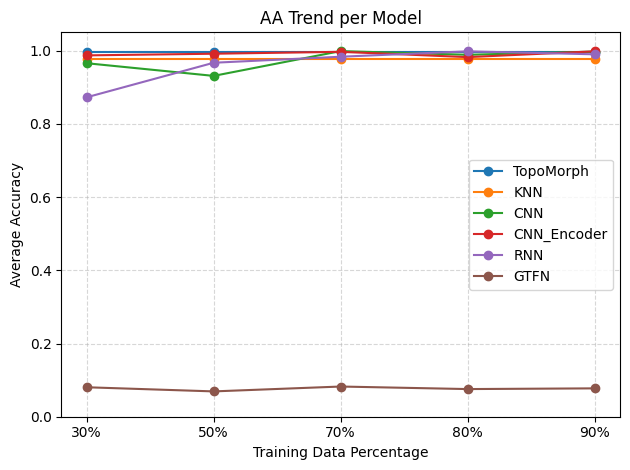

In [112]:
import matplotlib.pyplot as plt

def plot_metric_trend(results_by_percent, metric_name, ylabel):
    models = list(next(iter(results_by_percent.values())).keys())  # all model names
    percentages = sorted(results_by_percent.keys(), key=lambda x: int(x.strip('%')))
    
    for model in models:
        metric_values = [results_by_percent[p][model][metric_name] for p in percentages]
        plt.plot(percentages, metric_values, marker='o', label=model)

    plt.title(f'{metric_name} Trend per Model')
    plt.xlabel('Training Data Percentage')
    plt.ylabel(ylabel)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot OA and AA
plot_metric_trend(results_by_percent, "OA", "Overall Accuracy")
plot_metric_trend(results_by_percent, "AA", "Average Accuracy")

In [16]:
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, jaccard_score,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

In [17]:
y_probs = new_model.predict([X_test, topo_test], verbose=0)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
miou = jaccard_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
aa = np.mean(f1_score(y_true, y_pred, average=None))  # Same as macro F1
f1_per_class = f1_score(y_true, y_pred, average=None)
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

print("OA:", oa)
print("Kappa:", kappa)
print("mIoU:", miou)
print("Classification report:\n", classification_report(y_true, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

results["Proposed"] = {
    "OA": oa,
    "AA": aa,
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_macro,
    "Kappa": kappa,
    "mIoU": miou,
    "F1_per_class": f1_per_class,
    "Precision_per_class": precision_per_class,
    "Recall_per_class": recall_per_class
}

OA: 0.9953846153846154
Kappa: 0.9949991152280788
mIoU: 0.9915613720235569
Classification report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        50
           3     1.0000    1.0000    1.0000        43
           4     0.9818    1.0000    0.9908        54
           5     1.0000    0.9815    0.9907        54
           6     1.0000    1.0000    1.0000        52
           7     1.0000    1.0000    1.0000        40
           8     1.0000    0.9841    0.9920        63
           9     0.9804    1.0000    0.9901        50
          10     1.0000    1.0000    1.0000        61
          11     1.0000    0.9722    0.9859        36
          12     0.9818    1.0000    0.9908        54
          13     1.0000    1.0000    1.0000        19

    accuracy                         0.9954       650
   macro avg     0.9960    0.9956   

In [18]:
# Save the trained model to an HDF5 file
new_model.save("botswana_trained.h5")

In [20]:
# ----------- SVM -----------
svm = SVC(kernel='rbf')
svm.fit(X_train.reshape((X_train.shape[0], -1)), np.argmax(y_train, axis=1))
y_pred = svm.predict(X_test.reshape((X_test.shape[0], -1)))
results["SVM"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}


In [21]:
# ----------- KNN -----------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train.reshape((X_train.shape[0], -1)), np.argmax(y_train, axis=1))
y_pred = knn.predict(X_test.reshape((X_test.shape[0], -1)))
results["KNN"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}


In [57]:
# ----------- CNN -----------
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(cnn.predict(X_test), axis=1)
results["CNN"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [23]:
# ----------- CNN Encoder -----------
inp = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu')(inp)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(x)
cnn_encoder = Model(inputs=inp, outputs=out)
cnn_encoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_encoder.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(cnn_encoder.predict(X_test), axis=1)
results["CNN Encoder"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [24]:
# ----------- RNN -----------
X_rnn_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2], X_train.shape[3]))
X_rnn_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2], X_test.shape[3]))

rnn = Sequential([
    LSTM(64, input_shape=(X_rnn_train.shape[1], X_rnn_train.shape[2])),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn.fit(X_rnn_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(rnn.predict(X_rnn_test), axis=1)

results["RNN"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [25]:
# ----------- GTFN (Topo input only) -----------
gtfn_input = Input(shape=(topo_train.shape[1],))
x = Dense(64, activation='relu')(gtfn_input)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
gtfn_model = Model(inputs=gtfn_input, outputs=output)
gtfn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gtfn_model.fit(topo_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(gtfn_model.predict(topo_test), axis=1)
results["gtfn"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [21]:
# ----------- Proposed (fine-tuned TopoMorph model you already trained) -----------
y_probs = new_model.predict([X_test, topo_test])
y_pred = np.argmax(y_probs, axis=1)
results["Proposed"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [22]:
def bold_max(df):
    for col in df.columns:
        if df[col].dtype != 'O':  # Skip if already object (e.g., contains strings)
            max_val = df[col].max()
            df[col] = df[col].apply(lambda x: f"\\textbf{{{x}}}" if x == max_val else str(x))
    return df


In [31]:
# ----------- Create Comparison Table -----------
# Step 1: Get number of classes from any model
num_classes = len(results[next(iter(results))]["F1_per_class"])

# Step 2: Build F1-per-class rows
data = {model: results[model]["F1_per_class"] for model in results}

# Step 3: Move "Proposed" to the end
if "Proposed" in data:
    proposed_data = data.pop("Proposed")
    data["Proposed"] = proposed_data

# Step 4: Create DataFrame
df = pd.DataFrame(data)

# Step 5: Add "Class" column (1-indexed)
df.insert(0, "Class", [i + 1 for i in range(num_classes)])

# Step 6: Add separator row
sep_row = ["-" for _ in df.columns]
df.loc["-" * 10] = sep_row

# Step 7: Add OA, AA, Kappa rows
oa_row = ["OA"] + [results[model]["OA"]*100 for model in df.columns[1:]]
aa_row = ["AA"] + [results[model]["AA"]*100 for model in df.columns[1:]]
kappa_row = ["Kappa"] + [results[model]["Kappa"]*100 for model in df.columns[1:]]

df.loc["OA"] = oa_row
df.loc["AA"] = aa_row
df.loc["Kappa"] = kappa_row

# Step 8: Round numeric values
def try_round(val):
    try:
        return round(float(val), 4)
    except:
        return val
def highlight_max(row):
    numeric_row = row[1:]  # Exclude "Class" column
    try:
        max_val = max(val for val in numeric_row if isinstance(val, (int, float)))
    except:
        return [""] * len(row)

    return ["" if i == 0 else f"font-weight: bold" if val == max_val else "" 
            for i, val in enumerate(row)]

# Apply bold style
styled_df = df.style.apply(highlight_max, axis=1)

# Display with formatting
display(styled_df)

#df = df.applymap(try_round)
#print(df.to_string(index=False))
#display(df)

,Class,SVM,KNN,CNN Encoder,RNN,gtfn,Proposed
0,1,1.000000,0.990654,1.000000,0.981132,0.092593,1.000000
1,2,0.974359,0.975610,1.000000,0.904762,0.000000,1.000000
2,3,1.000000,0.980392,0.725275,0.857143,0.084507,1.000000
3,4,0.966292,0.914894,0.808989,0.722222,0.037736,1.000000
4,5,0.981481,0.951456,0.888889,0.836735,0.119760,0.990826
5,6,0.981132,0.952381,0.875000,0.806202,0.083333,0.990654
6,7,1.000000,0.980769,0.916667,0.954128,0.043011,1.000000
7,8,0.962025,1.000000,0.829268,0.345679,0.000000,1.000000
8,9,0.992000,0.967742,0.833333,0.911765,0.099291,0.992000
9,10,0.990099,1.000000,0.785714,0.526316,0.141593,0.990099


In [103]:
results

{'Proposed': {'OA': 0.9953846153846154,
  'AA': 0.9957371489009287,
  'Precision': 0.9960020371785079,
  'Recall': 0.995559334845049,
  'F1': 0.9957371489009287,
  'Kappa': 0.9949991152280788,
  'mIoU': 0.9915613720235569,
  'F1_per_class': array([1.        , 1.        , 1.        , 1.        , 0.99082569,
         0.99065421, 1.        , 1.        , 0.992     , 0.99009901,
         1.        , 0.98591549, 0.99082569, 1.        ]),
  'Precision_per_class': array([1.        , 1.        , 1.        , 1.        , 0.98181818,
         1.        , 1.        , 1.        , 1.        , 0.98039216,
         1.        , 1.        , 0.98181818, 1.        ]),
  'Recall_per_class': array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.98148148, 1.        , 1.        , 0.98412698, 1.        ,
         1.        , 0.97222222, 1.        , 1.        ])},
 'SVM': {'OA': 0.9876923076923076,
  'AA': 0.9861637930063815,
  'Precision': 0.9869257976674856,
  'Recall': 0.98577097505668

In [ ]:
# Class numbers for Botswana (0 to 13)
num_classes = 14
class_labels = list(range(num_classes))

# Build row-wise comparison table
data = {model: list(metrics["F1"]) for model, metrics in results.items()}
df = pd.DataFrame(data, index=class_labels)

# Append a separator row
df.loc["—" * 5] = ["—" * 5] * len(df.columns)

# Add OA, AA, and Kappa below the line
df.loc["OA"] = [metrics["OA"]*100 for metrics in results.values()]
df.loc["AA"] = [metrics["AA"]*100 for metrics in results.values()]
df.loc["Kappa"] = [metrics["Kappa"]*100 for metrics in results.values()]

# Round numeric values
df = df.round(4)

# Display
display(df)

In [95]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Flatten label from one-hot
y_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Prepare results dict
results_pct_split = {}

# Define sample percentages
for pct in [0.1, 0.3, 0.5,0.8,0.9]:
    # Stratified sub-sample of training data
    X_sub, _, topo_sub, _, y_sub, _ = train_test_split(
        X_train, topo_train, y_flat, train_size=pct, stratify=y_flat, random_state=42
    )

    # Combine spatial and topo features (reshape to 2D)
    X_combined_sub = np.concatenate([
        X_sub.reshape((X_sub.shape[0], -1)),
        topo_sub
    ], axis=1)

    X_combined_test = np.concatenate([
        X_test.reshape((X_test.shape[0], -1)),
        topo_test
    ], axis=1)

    # Train SVM
    svm = SVC(kernel='rbf')
    svm.fit(X_combined_sub, y_sub)

    # Predict
    y_pred = svm.predict(X_combined_test)

    # Metrics
    oa = accuracy_score(y_test_flat, y_pred)
    kappa = cohen_kappa_score(y_test_flat, y_pred)
    aa = np.mean(f1_score(y_test_flat, y_pred, average=None))

    # Save
    results_pct_split[f"{int(pct*100)}%"] = {
        "OA": oa,
        "AA": aa,
        "Kappa": kappa
    }

In [96]:
sample_sizes = list(results_pct_split.keys())
oa_values = [results_pct_split[s]['OA'] for s in sample_sizes]
aa_values = [results_pct_split[s]['AA'] for s in sample_sizes]
kappa_values = [results_pct_split[s]['Kappa'] for s in sample_sizes]

In [97]:
oa_values

[0.8107692307692308,
 0.9446153846153846,
 0.9723076923076923,
 0.9861538461538462,
 0.9876923076923076]

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import numpy as np

def evaluate_model_over_samples(model_name, model_builder, X_train, y_train, X_test, y_test, sample_percents, results):
    y_train_flat = np.argmax(y_train, axis=1)
    y_test_flat = np.argmax(y_test, axis=1)

    for pct in sample_percents:
        # Stratified sampling
        X_sub, _, y_sub, _ = train_test_split(
            X_train, y_train_flat, train_size=pct, stratify=y_train_flat, random_state=42
        )

        # Rebuild fresh model each time
        model = model_builder()

        # Train model
        if "fit" in dir(model):  # DL models or sklearn
            if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):  # sklearn models
                model.fit(X_sub.reshape(len(X_sub), -1), y_sub)
                y_pred = model.predict(X_test.reshape(len(X_test), -1))
            else:  # Deep learning models
                model.fit(X_sub, to_categorical(y_sub), epochs=30, batch_size=32, verbose=0, validation_split=0.1)
                y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        else:
            raise ValueError("Unsupported model type")

        # Compute metrics
        oa = accuracy_score(y_test_flat, y_pred)
        aa = np.mean(f1_score(y_test_flat, y_pred, average=None))
        kappa = cohen_kappa_score(y_test_flat, y_pred)

        results.setdefault(model_name, {})
        results[model_name][f"{int(pct*100)}%"] = {
            "OA": oa,
            "AA": aa,
            "Kappa": kappa
        }

In [99]:
from keras.utils import to_categorical

def build_cnn():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

evaluate_model_over_samples("CNN", build_cnn, X_train, y_train, X_test, y_test, [0.3, 0.5, 0.7,0.8,0.9], results_samples)


In [101]:
from sklearn.svm import SVC

def build_svm():
    return SVC(kernel='rbf')

evaluate_model_over_samples("SVM", build_svm, X_train, y_train, X_test, y_test, [0.3, 0.5, 0.7,0.8,0.9], results_samples)

In [102]:
from sklearn.neighbors import KNeighborsClassifier

def build_knn():
    return KNeighborsClassifier(n_neighbors=5)

evaluate_model_over_samples("KNN", build_knn, X_train, y_train, X_test, y_test, [0.3, 0.5, 0.7,0.8,0.9], results_samples)


In [ ]:
def build_gtfn():
    model = Sequential([...])  # your GTFN code
    model.compile(...)
    return model

evaluate_model_over_samples("GTFN", build_gtfn, topo_train, y_train, topo_test, y_test, [0.3, 0.5, 0.7,0.8,0.9], results_samples)

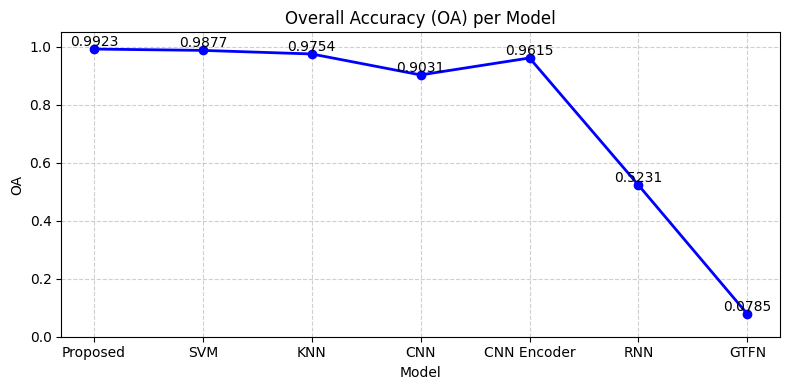

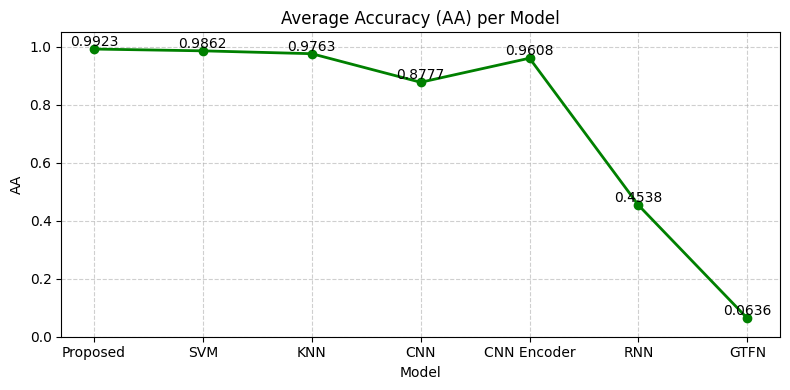

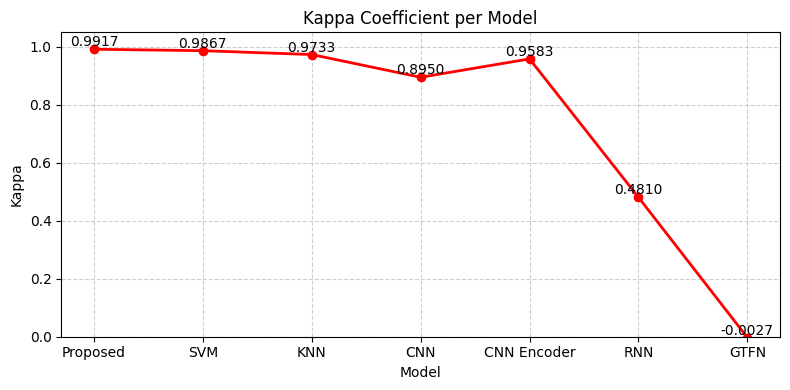

In [26]:
import matplotlib.pyplot as plt

# Extract model names directly from results dictionary
model_names = list(results.keys())

# Extract metric values dynamically
oa_values = [results[m]['OA'] for m in model_names]
aa_values = [results[m]['AA'] for m in model_names]
kappa_values = [results[m]['Kappa'] for m in model_names]

# General plotting function
def plot_metric(metric_values, title, ylabel, color):
    plt.figure(figsize=(8, 4))
    plt.plot(model_names, metric_values, marker='o', linestyle='-', color=color, linewidth=2)
    plt.xlabel('Model')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add value labels
    for x, y in zip(model_names, metric_values):
        plt.text(x, y + 0.01, f'{y:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

# Plot all metrics
plot_metric(oa_values, 'Overall Accuracy (OA) per Model', 'OA', 'blue')
plot_metric(aa_values, 'Average Accuracy (AA) per Model', 'AA', 'green')
plot_metric(kappa_values, 'Kappa Coefficient per Model', 'Kappa', 'red')

In [ ]:
df_bold = bold_max(df_comparison.copy())

# Export to LaTeX
latex_code = df_bold.to_latex(escape=False, column_format="l" + "c" * len(df_bold.columns))
#print(latex_code)

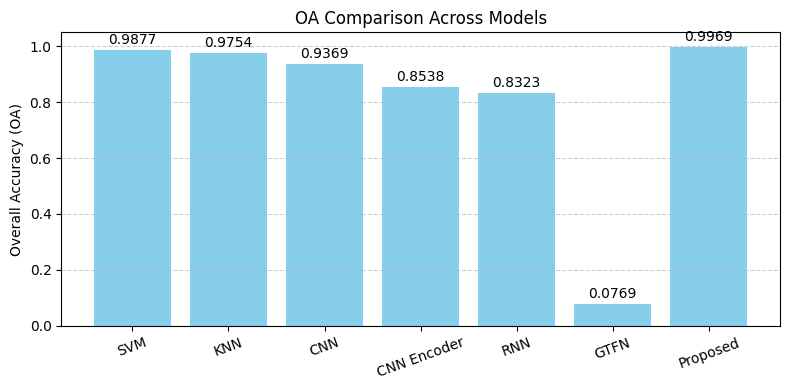

In [30]:
# One OA per model — taken directly from your dict
oa_values = {
    'SVM': 0.9877,
    'KNN': 0.9754,
    'CNN': 0.9369,
    'CNN Encoder': 0.8538,
    'RNN': 0.8323,
    'GTFN': 0.0769,
    'Proposed': 0.9969
}

methods = list(oa_values.keys())
oas = list(oa_values.values())

# Bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(methods, oas, color='skyblue')
plt.ylabel("Overall Accuracy (OA)")
plt.title("OA Comparison Across Models")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=20)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

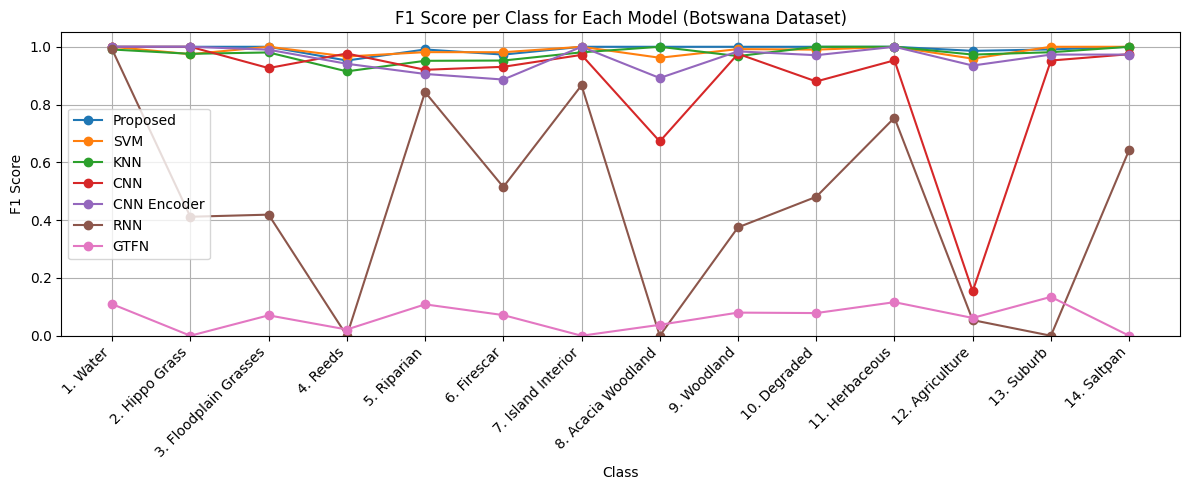

In [29]:
import matplotlib.pyplot as plt

# Replace class numbers with Botswana class names
class_labels = [
    "1. Water", "2. Hippo Grass", "3. Floodplain Grasses", "4. Reeds", "5. Riparian", "6. Firescar", 
    "7. Island Interior", "8. Acacia Woodland", "9. Woodland", "10. Degraded", "11. Herbaceous", 
    "12. Agriculture", "13. Suburb", "14. Saltpan"
]

plt.figure(figsize=(12, 5))

# Plot F1 scores for each model per class
for model, metric in results.items():
    plt.plot(class_labels, metric['F1'], marker='o', label=model)

plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("F1 Score per Class for Each Model (Botswana Dataset)")
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

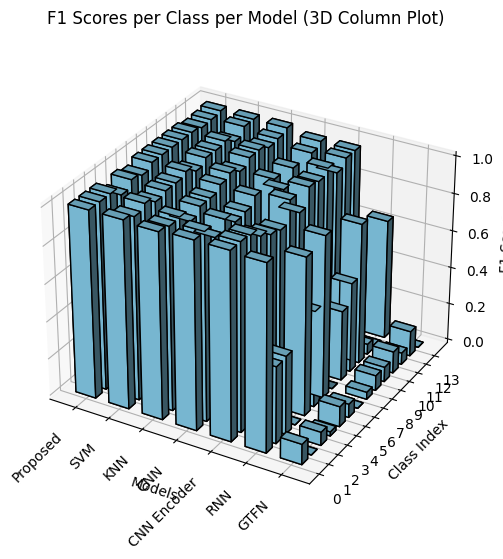

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # Ensure this import exists

# Extract model names and number of classes dynamically
models = list(results.keys())
num_models = len(models)
num_classes = len(next(iter(results.values()))['F1'])

# Create mesh grid for bar positions
xpos, ypos = np.meshgrid(np.arange(num_models), np.arange(num_classes), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Extract F1 values for each model
f1_vals = np.array([results[model]['F1'] for model in models])
dz = f1_vals.flatten()

# Bar dimensions
dx = dy = 0.6

# Plotting
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='skyblue', edgecolor='black')

# Axis labels and ticks
ax.set_xlabel('Models')
ax.set_ylabel('Class Index')
ax.set_zlabel('F1 Score')

ax.set_xticks(np.arange(num_models) + dx / 2)
ax.set_xticklabels(models, rotation=45, ha='right')

ax.set_yticks(np.arange(num_classes))
#bot_class_labels = ["Water", "Hippo Grass", "Floodplain Grasses", "Reeds", "Riparian", "Firescar", "Island Interior", "Acacia Woodland", "Woodland", "Degraded", "Herbaceous", "Agriculture", "Suburb", "Saltpan"]
#ax.set_yticklabels(bot_class_labels)
ax.set_yticklabels([str(i) for i in range(num_classes)])

ax.set_title('F1 Scores per Class per Model (3D Column Plot)', pad=20)

plt.tight_layout()
plt.show()

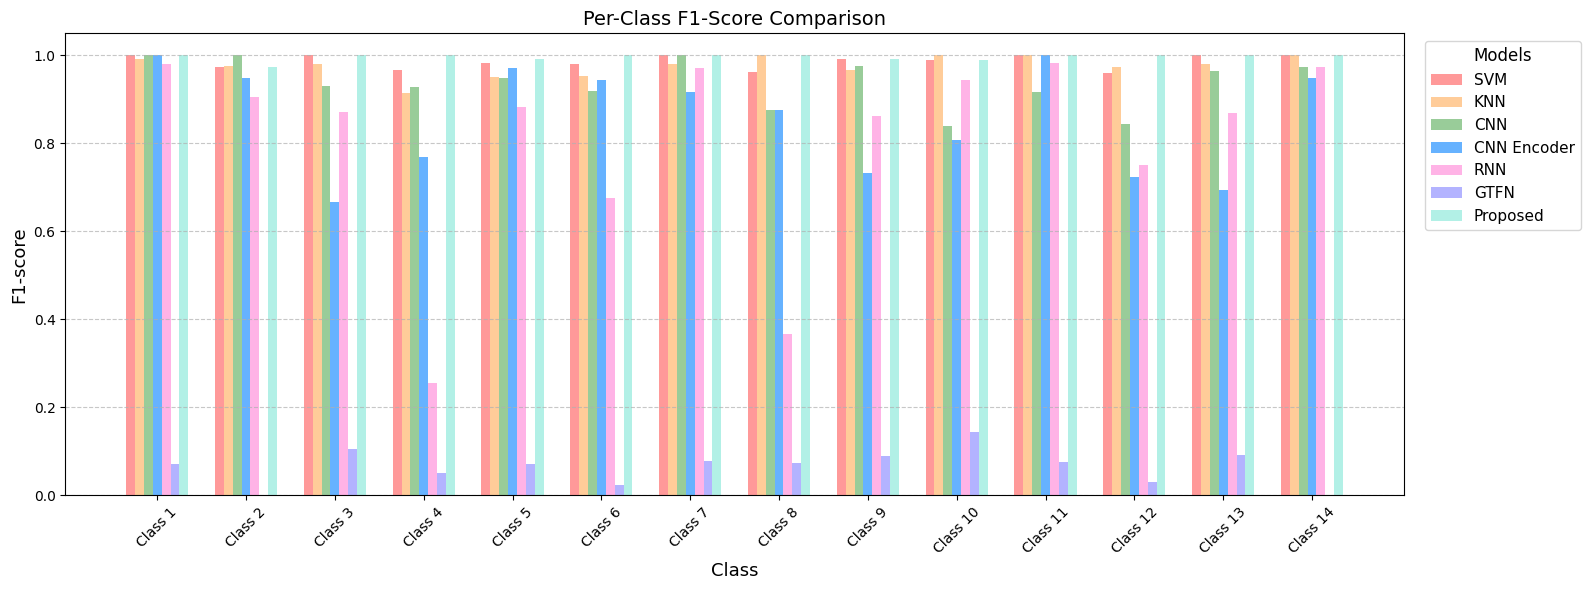

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Use Seaborn-like style
plt.style.use('seaborn-v0_8-muted')

# Prepare data
class_labels = [f'Class {i+1}' for i in range(len(next(iter(data.values()))["F1"]))]
model_names = list(data.keys())
f1_scores = [data[model]['F1'] for model in model_names]

# Transpose to group F1-scores by class
f1_scores_by_class = list(zip(*f1_scores))

# Colors (pastel palette)
colors = ['#FF9999', '#FFCC99', '#99CC99', '#66B2FF', '#FFB3E6', '#B3B3FF', '#B2F0E6', '#F6CBA0']

# Plot setup
x = np.arange(len(class_labels))  # Class indices
bar_width = 0.1
fig, ax = plt.subplots(figsize=(16, 6))

# Plot bars for each model
for i, model in enumerate(model_names):
    scores = [f1[i] for f1 in f1_scores_by_class]
    ax.bar(x + i * bar_width, scores, width=bar_width, label=model, color=colors[i % len(colors)])

# Label formatting
ax.set_xlabel('Class', fontsize=13)
ax.set_ylabel('F1-score', fontsize=13)
ax.set_title('Per-Class F1-Score Comparison', fontsize=14)
ax.set_xticks(x + bar_width * (len(model_names) - 1) / 2)
ax.set_xticklabels(class_labels, rotation=45, fontsize=10)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
ax.legend(title='Models', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()

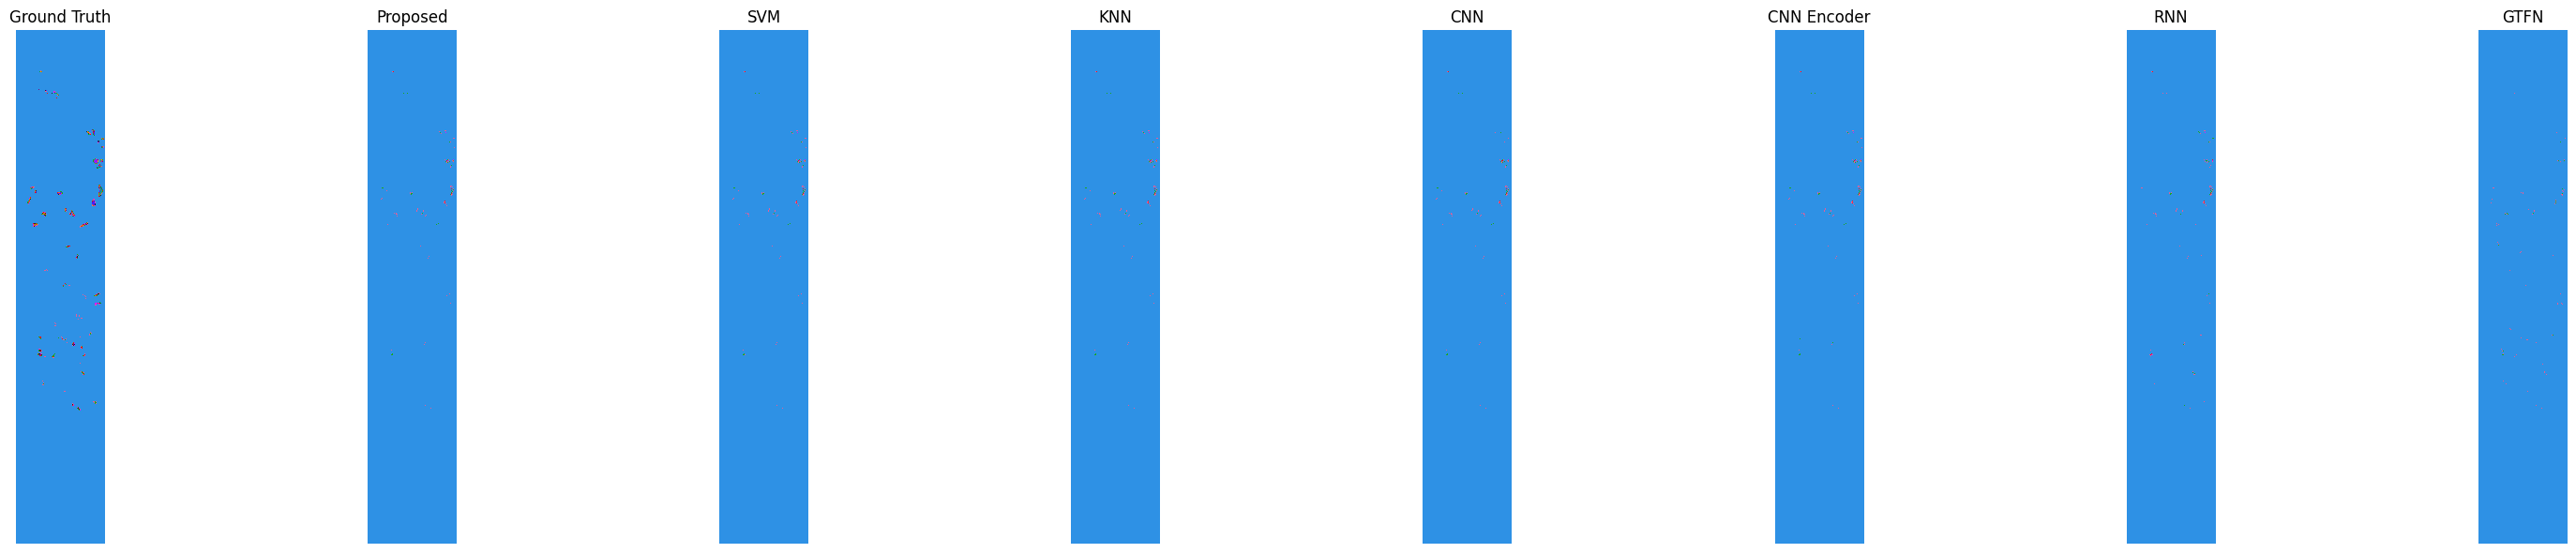

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# --- 1. Reconstruct 2D prediction map ---
def reconstruct_prediction_map(y_pred, test_indices, height, width):
    pred_map = np.zeros((height * width,), dtype=np.uint8)
    pred_map[:] = 0  # background
    pred_map[test_indices] = y_pred + 1  # +1 because 0 is background
    return pred_map.reshape((height, width))

# --- 2. Get indices of test pixels from original GT ---
valid_indices = np.where(gt.flatten() > 0)[0]
_, test_indices = train_test_split(valid_indices, test_size=0.2, stratify=gt.flatten()[valid_indices], random_state=42)

# --- 3. Prepare reconstructed maps ---
height, width = gt.shape
prediction_maps = []

# Ground Truth
prediction_maps.append(gt)

# Add all model predictions
for model in results.keys():
    if model == "Proposed":
        y_probs = new_model.predict([X_test, topo_test], verbose=0)
        y_pred = np.argmax(y_probs, axis=1)
    elif model == "SVM":
        y_pred = svm.predict(X_test.reshape((X_test.shape[0], -1)))
    elif model == "KNN":
        y_pred = knn.predict(X_test.reshape((X_test.shape[0], -1)))
    elif model == "CNN":
        y_pred = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
    elif model == "CNN Encoder":
        y_pred = np.argmax(cnn_encoder.predict(X_test, verbose=0), axis=1)
    elif model == "RNN":
        y_pred = np.argmax(rnn.predict(X_rnn_test, verbose=0), axis=1)
    elif model == "GTFN":
        y_pred = np.argmax(gtfn_model.predict(topo_test, verbose=0), axis=1)
    
    pred_map = reconstruct_prediction_map(y_pred, test_indices, height, width)
    prediction_maps.append(pred_map)

# --- 4. Plot ---
titles = ["Ground Truth"] + list(results.keys())
num_classes = len(np.unique(gt)) - 1  # exclude background (0)
#cmap = plt.cm.get_cmap("nipy_spectral", num_classes)
#cmap = plt.cm.get_cmap("tab20b", num_classes)  # Better blue-ish variety

from matplotlib.colors import ListedColormap

# Custom colormap (trimmed to num_classes)
cmap = ListedColormap([
    "#2E91E5", "#E15F99", "#1CA71C", "#FB0D0D", "#DA16FF", "#222A2A",
    "#B68100", "#750D86", "#EB663B", "#511CFB", "#00A08B", "#FB9E07",
    "#9B19F5", "#DCB0F2", "#FF96C5", "#B2F5FF"
][:num_classes])

# Plot
fig, axes = plt.subplots(1, len(prediction_maps), figsize=(4 * len(prediction_maps), 6))
for ax, pred_map, title in zip(axes, prediction_maps, titles):
    ax.imshow(pred_map, cmap=cmap, vmin=1, vmax=num_classes)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [37]:
from sklearn.model_selection import train_test_split
import numpy as np

# Get indices of labeled pixels
all_indices = np.argwhere(gt > 0)  # shape: (N, 2) where N is number of labeled pixels
all_labels = gt[gt > 0]  # corresponding labels

# Encode coordinates into linear indices for easier splitting
flat_indices = np.ravel_multi_index(all_indices.T, gt.shape)  # shape (N,)

# 60% train, 20% val, 20% test
train_idx, test_idx = train_test_split(flat_indices, stratify=all_labels, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(test_idx, stratify=all_labels[np.isin(flat_indices, test_idx)], test_size=0.5, random_state=42)

# Optional: decode back to 2D coordinates if needed
indices_train = np.array(np.unravel_index(train_idx, gt.shape)).T  # shape: (N_train, 2)
indices_val = np.array(np.unravel_index(val_idx, gt.shape)).T
indices_test = np.array(np.unravel_index(test_idx, gt.shape)).T

In [61]:
model_preds = {
    "SVM": svm.predict(X_test.reshape((X_test.shape[0], -1))),
    "KNN": knn.predict(X_test.reshape((X_test.shape[0], -1))),
    "CNN": np.argmax(cnn.predict(X_test), axis=1),
    "CNN-Encoder": np.argmax(cnn_encoder.predict(X_test), axis=1),
    "RNN": np.argmax(rnn.predict(X_rnn_test), axis=1),
    "GTFN": np.argmax(gtfn_model.predict(topo_test), axis=1),
    "Proposed": np.argmax(new_model.predict([X_test, topo_test]), axis=1),
}


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [68]:
# Predict on all patches (X_patches) instead of only X_test
all_preds = {
    "SVM": svm.predict(X_patches.reshape((X_patches.shape[0], -1))),
    "KNN": knn.predict(X_patches.reshape((X_patches.shape[0], -1))),
    "CNN": np.argmax(cnn.predict(X_patches), axis=1),
    "CNN-Encoder": np.argmax(cnn_encoder.predict(X_patches), axis=1),
    "RNN": np.argmax(rnn.predict(X_rnn_test), axis=1),  
    "GTFN": np.argmax(gtfn_model.predict(topo_features), axis=1),
    "Proposed": np.argmax(new_model.predict([X_patches, topo_features]), axis=1),
}

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [70]:
# Prepare RNN input for the full dataset (3248 samples)
X_rnn_full = X_patches.reshape((X_patches.shape[0], X_patches.shape[1] * X_patches.shape[2], X_patches.shape[3]))

In [71]:
all_preds = {
    "SVM": svm.predict(X_patches.reshape((X_patches.shape[0], -1))),
    "KNN": knn.predict(X_patches.reshape((X_patches.shape[0], -1))),
    "CNN": np.argmax(cnn.predict(X_patches), axis=1),
    "CNN-Encoder": np.argmax(cnn_encoder.predict(X_patches), axis=1),
    "RNN": np.argmax(rnn.predict(X_rnn_full), axis=1),  # FIXED LINE
    "GTFN": np.argmax(gtfn_model.predict(topo_features), axis=1),
    "Proposed": np.argmax(new_model.predict([X_patches, topo_features]), axis=1),
}

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [72]:
def reconstruct_full_map(flat_preds, gt_mask, height, width):
    pred_map = np.zeros((height, width), dtype=np.uint8)
    pred_map[gt_mask] = flat_preds + 1  # +1 for 1-based indexing
    return pred_map

gt_mask = (gt > 0)
height, width = gt.shape

pred_maps = {}
for name, preds in all_preds.items():  # ← use `all_preds`, not `model_preds`
    pred_maps[name] = reconstruct_full_map(preds, gt_mask, height, width)


In [73]:
pred_maps

{'SVM': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'KNN': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'CNN': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'CNN-Encoder': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'RNN': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..

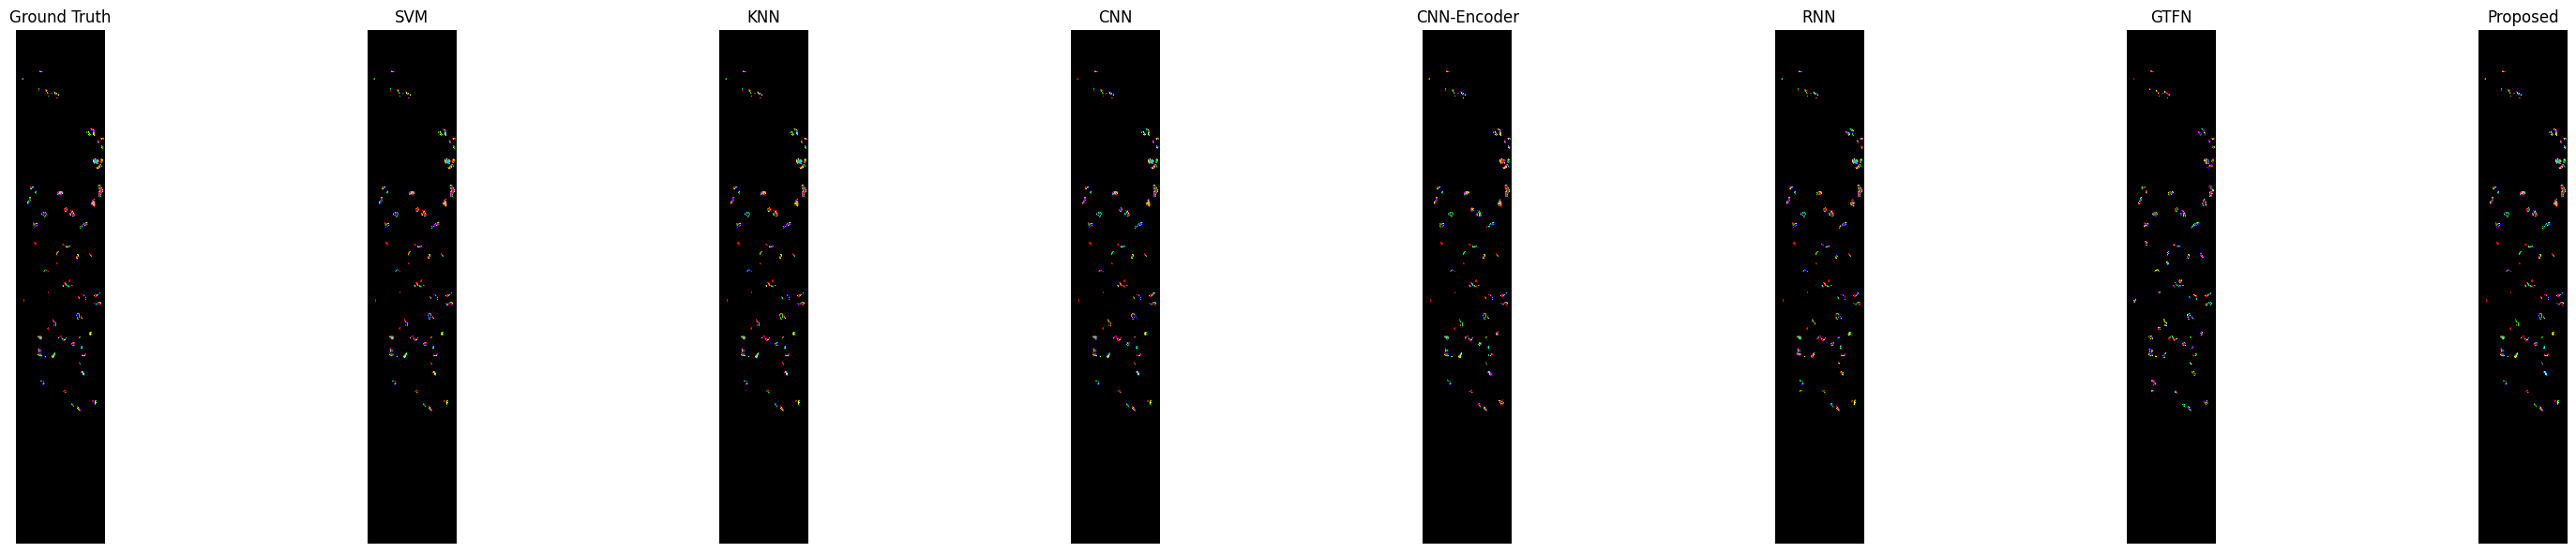

In [74]:
import matplotlib.pyplot as plt

# Example colormap: customize based on number of classes
from matplotlib import colors
cmap = colors.ListedColormap([
    "#000000", "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF", "#FF00FF",
    "#800000", "#008000", "#000080", "#808000", "#008080", "#800080", "#C0C0C0",
    "#FFA500", "#A52A2A", "#7FFF00", "#DC143C", "#00CED1", "#9400D3"
])  # Use as many as your number of classes

num_classes = len(np.unique(gt)) - 1  # exclude background 0
titles = ["Ground Truth"] + list(pred_maps.keys())
maps = [gt] + list(pred_maps.values())

# --- Plotting ---
fig, axes = plt.subplots(1, len(maps), figsize=(4 * len(maps), 6))
for ax, img, title in zip(axes, maps, titles):
    im = ax.imshow(img, cmap=cmap, vmin=0, vmax=num_classes)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [76]:
print(data_selected.shape)

(1476, 256, 30)


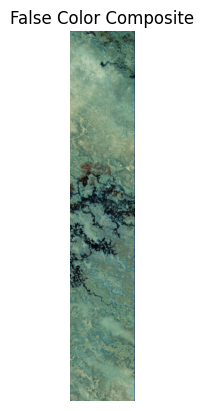

In [77]:
import matplotlib.pyplot as plt

# Example bands: adjust based on Botswana dataset's spectrum
nir_band, red_band, green_band = 29, 19, 9  # keep within 0–29

false_color = data_selected[:, :, [nir_band, red_band, green_band]]
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min())  # normalize

plt.imshow(false_color)
plt.title("False Color Composite")
plt.axis('off')
plt.show()


In [78]:
pred_maps = {}
for name, preds in all_preds.items():
    pred_maps[name] = reconstruct_full_map(preds, gt_mask, height, width)

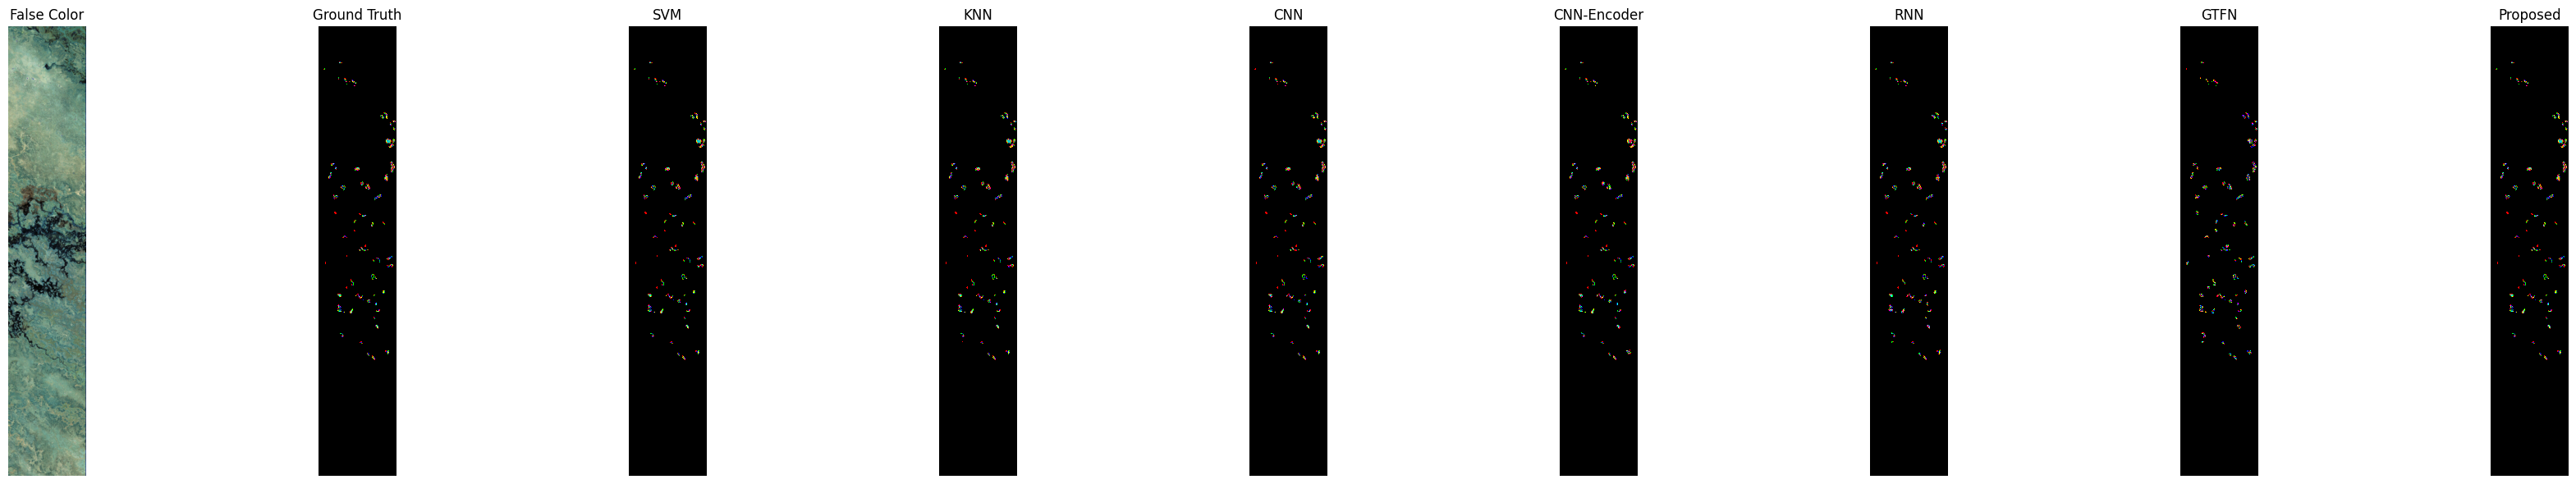

In [79]:
# Add GT to the maps
visual_maps = {
    "False Color": false_color,
    "Ground Truth": gt
}
visual_maps.update(pred_maps)  # Add all predicted maps

# Plot
fig, axes = plt.subplots(1, len(visual_maps), figsize=(4 * len(visual_maps), 6))
for ax, (name, img) in zip(axes, visual_maps.items()):
    if name == "False Color":
        ax.imshow(img)
    else:
        ax.imshow(img, cmap=cmap, vmin=0, vmax=num_classes)  # use your colormap from before
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [80]:
print("HSI cube shape:", data_selected.shape)  # (height, width, bands)


HSI cube shape: (1476, 256, 30)


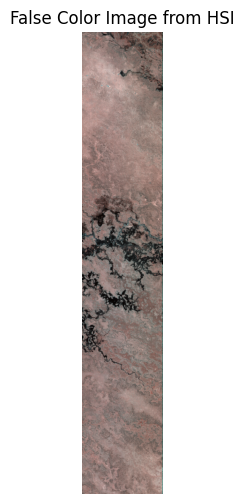

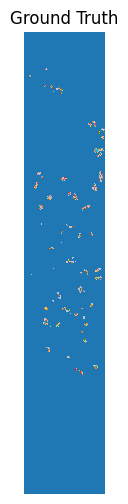

In [82]:
nir_band, red_band, green_band = 20, 10, 5  # must be < data_selected.shape[2]

false_color = data_selected[:, :, [nir_band, red_band, green_band]]
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min())  # Normalize to [0, 1]

plt.figure(figsize=(6, 6))
plt.imshow(false_color)
plt.title("False Color Image from HSI")
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(gt, cmap='tab20', vmin=0)
plt.title("Ground Truth")
plt.axis('off')
plt.show()


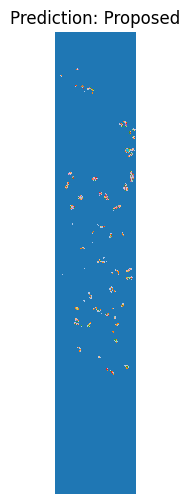

In [83]:
plt.figure(figsize=(6, 6))
plt.imshow(pred_maps["Proposed"], cmap='tab20', vmin=0)
plt.title("Prediction: Proposed")
plt.axis('off')
plt.show()

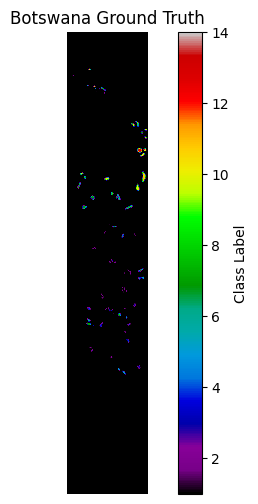

In [86]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap='nipy_spectral', vmin=1, vmax=np.max(gt))
plt.title("Botswana Ground Truth")
plt.axis("off")
plt.colorbar(label="Class Label")
plt.show()

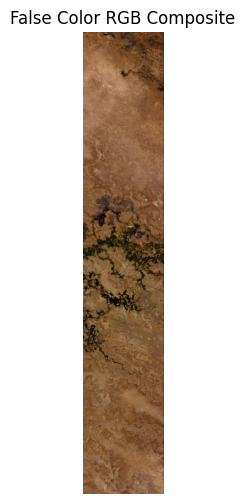

In [88]:
rgb_bands = [50, 27, 17]  # You can change these
rgb_image = data_scaled[:, :, rgb_bands]

# Normalize per channel to [0,1]
rgb_image -= rgb_image.min()
rgb_image /= rgb_image.max()

plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.title("False Color RGB Composite")
plt.axis("off")
plt.show()

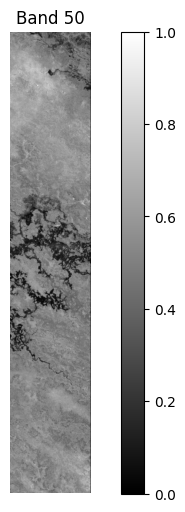

In [87]:
band_idx = 50  # any band index between 0 and 144
plt.figure(figsize=(8, 6))
plt.imshow(data_scaled[:, :, band_idx], cmap='gray')
plt.title(f"Band {band_idx}")
plt.axis("off")
plt.colorbar()
plt.show()

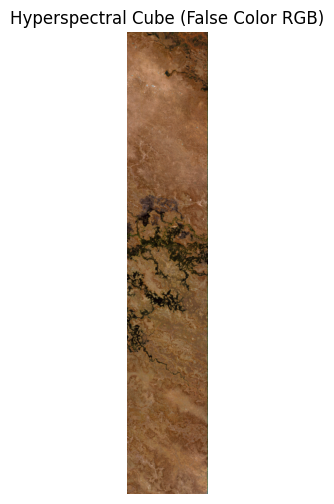

In [89]:
import matplotlib.pyplot as plt

rgb_bands = [50, 27, 17]
rgb_image = data_scaled[:, :, rgb_bands]

# Normalize RGB to [0, 1]
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)
plt.title("Hyperspectral Cube (False Color RGB)")
plt.axis('off')
plt.show()